# Visualization and Interpretation

### 1. Logistic Curve

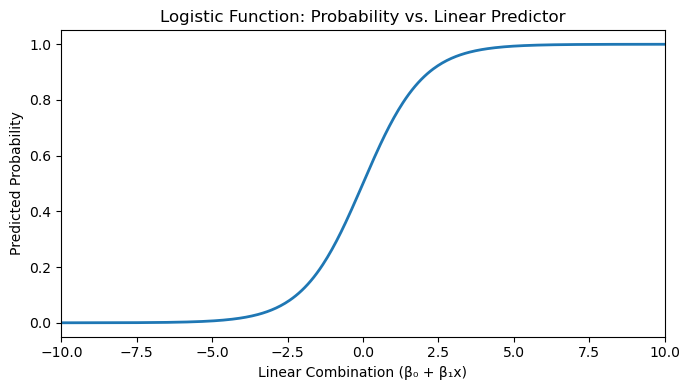

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 400)
p = 1 / (1 + np.exp(-x))

plt.figure(figsize=(7, 4))
plt.plot(x, p, linewidth=2)
plt.title("Logistic Function: Probability vs. Linear Predictor")
plt.xlabel("Linear Combination (β₀ + β₁x)")
plt.ylabel("Predicted Probability")
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 10)
plt.tight_layout()
plt.show()

### 2. Marginal Effect Plot

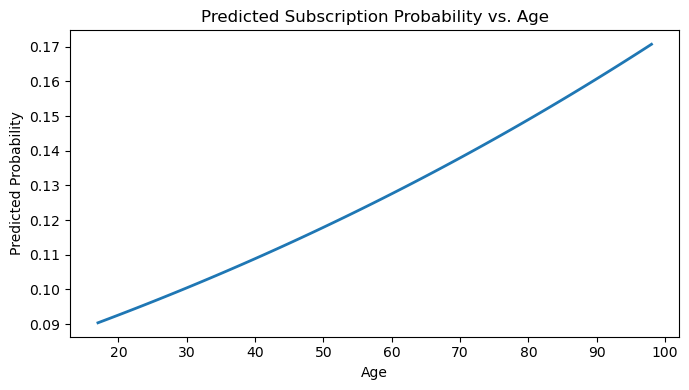

In [2]:
import pandas as pd
import statsmodels.api as sm

# Example: logistic model on age and contact frequency
df = pd.read_csv("bank-additional-full.csv", sep=";")
df["y"] = (df["y"] == "yes").astype(int)
X = sm.add_constant(df[["age", "campaign"]])
model = sm.Logit(df["y"], X).fit(disp=False)

# Predict probability as age varies
age_seq = np.linspace(df["age"].min(), df["age"].max(), 100)
X_pred = pd.DataFrame({"const": 1, "age": age_seq, "campaign": df["campaign"].mean()})
p_pred = model.predict(X_pred)

plt.figure(figsize=(7, 4))
plt.plot(age_seq, p_pred, linewidth=2)
plt.title("Predicted Subscription Probability vs. Age")
plt.xlabel("Age")
plt.ylabel("Predicted Probability")
plt.tight_layout()
plt.show()

### 3. Probability Distribution by Predictor Category

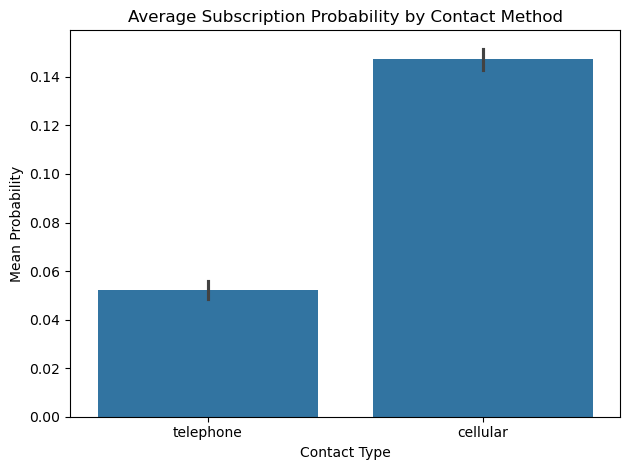

In [3]:
import seaborn as sns

df["y_label"] = df["y"].map({1: "Yes", 0: "No"})
sns.barplot(data=df, x="contact", y="y", estimator=np.mean, order=df["contact"].unique())
plt.title("Average Subscription Probability by Contact Method")
plt.xlabel("Contact Type")
plt.ylabel("Mean Probability")
plt.tight_layout()
plt.show()

### 4. Calibration Plot

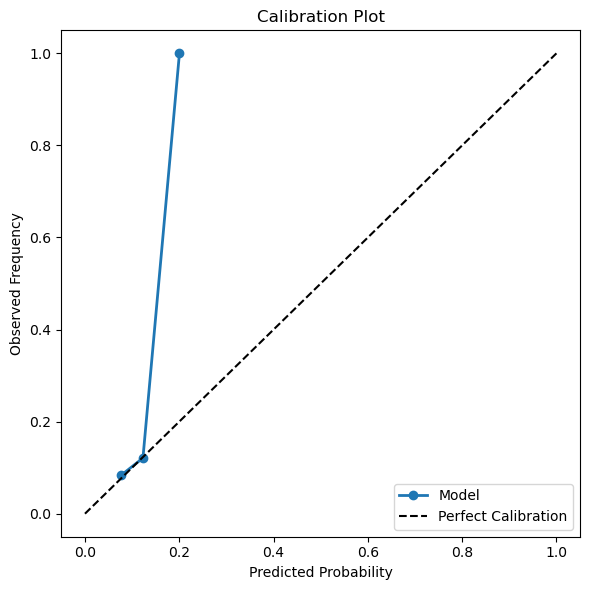

In [4]:
from sklearn.calibration import calibration_curve

y_true = df["y"]
y_pred = model.predict(sm.add_constant(df[["age", "campaign"]]))
prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", linewidth=2, label="Model")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.title("Calibration Plot")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.legend()
plt.tight_layout()
plt.show()

### 5. Partial Dependence Interpretation

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.utils import check_random_state

# -----------------------
# Setup
# -----------------------
OUTDIR = "figures_pdp"
os.makedirs(OUTDIR, exist_ok=True)

def clean_axes(ax):
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", which="major", labelsize=10)

# -----------------------
# Load data (fallback to synthetic if file missing)
# -----------------------
def load_or_simulate():
    try:
        df = pd.read_csv("bank-additional-full.csv", sep=";")
        df = df.drop(columns=[c for c in ["duration"] if c in df.columns])  # leakage
        df["y"] = (df["y"].astype(str).str.strip().str.lower() == "yes").astype(int)
        return df
    except Exception:
        rng = check_random_state(42)
        n = 8000
        age = rng.normal(41, 10, n).clip(18, 90)
        campaign = rng.poisson(2.5, n).clip(0, 12)
        contact = rng.choice(["cellular","telephone"], size=n, p=[0.7,0.3])
        month = rng.choice(["mar","apr","may","jun","jul","aug","sep","oct","nov","dec"], size=n)
        lin = -2.0 + 0.015*(age-41) - 0.18*(campaign-2.5) + (contact=="cellular")*0.25 + (month=="mar")*0.15
        p = 1/(1+np.exp(-lin))
        y = rng.binomial(1, p, n)
        return pd.DataFrame({"age":age,"campaign":campaign,"contact":contact,"month":month,"y":y})

df = load_or_simulate()

# -----------------------
# Select features
# -----------------------
num_features = [c for c in ["age","campaign"] if c in df.columns]
cat_candidates = [c for c in ["job","marital","education","default","housing","loan","contact","month","day_of_week","poutcome"] if c in df.columns]
cat_features = cat_candidates[:4]  # keep it compact for speed/clarity

X = df[num_features + cat_features].copy()
y = df["y"].astype(int).values

# -----------------------
# Pipeline: scale numerics, one-hot categoricals, logistic regression
# -----------------------
preproc = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), num_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features),
    ],
    remainder="drop",
)

clf = Pipeline(steps=[
    ("prep", preproc),
    ("logit", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

clf.fit(X, y)

# -----------------------
# PDP utility: 1D partial dependence for a numeric column
# -----------------------
def pdp_1d(model, X_df, feature, grid=None, fixed=None, n_points=60):
    X_ref = X_df.copy()
    if fixed:
        for k, v in fixed.items():
            X_ref[k] = v
    if grid is None:
        lo, hi = np.percentile(X_df[feature].dropna(), [1, 99])
        grid = np.linspace(lo, hi, n_points)
    preds = []
    for val in grid:
        X_tmp = X_ref.copy()
        X_tmp[feature] = val
        p = model.predict_proba(X_tmp)[:,1].mean()
        preds.append(p)
    return grid, np.array(preds)

# -----------------------
# PDP utility: 2D partial dependence for two numeric columns
# -----------------------
def pdp_2d(model, X_df, f1, f2, grid1=None, grid2=None, n1=50, n2=50, fixed=None):
    X_ref = X_df.copy()
    if fixed:
        for k, v in fixed.items():
            X_ref[k] = v
    if grid1 is None:
        lo1, hi1 = np.percentile(X_df[f1].dropna(), [1, 99])
        grid1 = np.linspace(lo1, hi1, n1)
    if grid2 is None:
        lo2, hi2 = np.percentile(X_df[f2].dropna(), [1, 99])
        grid2 = np.linspace(lo2, hi2, n2)
    Z = np.zeros((n1, n2))
    # Vectorized over second axis
    for i, g1 in enumerate(grid1):
        X_tmp = X_ref.copy()
        X_tmp[f1] = g1
        # batch predictions across grid2
        X_batch = []
        for g2 in grid2:
            row = X_tmp.copy()
            row[f2] = g2
            X_batch.append(row)
        X_big = pd.concat(X_batch, axis=0, ignore_index=True)
        Z_row = model.predict_proba(X_big)[:,1].reshape(-1)
        # average over the reference rows for each g2
        # We built X_big as stack of copies of X_tmp for each g2; average per block:
        # Actually, we want mean across rows for each g2 value:
        # We arranged as [X_tmp@g2_1 (len=n_ref), X_tmp@g2_2, ...], so compute means by chunks.
        n_ref = len(X_ref)
        Z[i, :] = [Z_row[j*n_ref:(j+1)*n_ref].mean() for j in range(len(grid2))]
    return grid1, grid2, Z

# -----------------------
# 1D PDP: age
# -----------------------
if "age" in num_features:
    gx, gy = pdp_1d(clf, X, "age")
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(gx, gy, lw=2)
    ax.set_title("Partial Dependence: P(y=1) vs Age (Logistic)")
    ax.set_xlabel("Age")
    ax.set_ylabel("Predicted probability")
    clean_axes(ax)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "pdp_age_logit.png"), dpi=300)
    plt.close()

# -----------------------
# 1D PDP: campaign
# -----------------------
if "campaign" in num_features:
    gx, gy = pdp_1d(clf, X, "campaign")
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(gx, gy, lw=2)
    ax.set_title("Partial Dependence: P(y=1) vs Campaign Contacts (Logistic)")
    ax.set_xlabel("Number of contacts in campaign")
    ax.set_ylabel("Predicted probability")
    clean_axes(ax)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "pdp_campaign_logit.png"), dpi=300)
    plt.close()

# -----------------------
# 2D PDP: age × campaign (contour)
# -----------------------
if set(["age","campaign"]).issubset(num_features):
    g1, g2, Z = pdp_2d(clf, X, "age", "campaign", n1=60, n2=40)
    fig, ax = plt.subplots(figsize=(7.5, 5.5))
    cs = ax.contourf(g2, g1, Z, levels=14)  # x: campaign, y: age
    cbar = plt.colorbar(cs, ax=ax)
    cbar.set_label("Predicted probability (P[y=1])")
    ax.set_title("2D Partial Dependence: Age × Campaign (Logistic)")
    ax.set_xlabel("Campaign contacts")
    ax.set_ylabel("Age")
    clean_axes(ax)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "pdp_age_x_campaign_logit.png"), dpi=300)
    plt.close()

print("Saved PDP figures in:", OUTDIR)
for f in sorted(os.listdir(OUTDIR)):
    print(" -", f)

Saved PDP figures in: figures_pdp
 - pdp_age_logit.png
 - pdp_age_x_campaign_logit.png
 - pdp_campaign_logit.png
